# Hybrid System: Content Based + Collaborative Filtering

Desarrollamos un modelo híbrido en el que combinamos los **embeddings de ítems obtenidos por CBF** (usando TF-IDF) con los **embeddings de ítems y usuarios generados por CF** (LightGCN). Esta representación conjunta se introduce en una red neuronal (MLP) que aprende a predecir la probabilidad de interacción, aprovechando tanto las relaciones estructurales del grafo como la información semántica de los ítems.

## Importación de librerías

In [1]:
# Reinstala PyTorch 2.3.0 con CUDA 12.1 (estable en Colab)
!pip install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Instala PyG y extensiones con soporte oficial
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install -q torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1

In [2]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.typing import Adj
from torch_sparse import SparseTensor, matmul
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.data import download_url, extract_zip
from torch_geometric.utils import structured_negative_sampling

In [3]:
# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Carga de datos

In [4]:
interactions = pd.read_csv('/content/interactions_filtered.csv')
books = pd.read_csv('/content/books_authors_genres.csv')
tfidf_df = pd.read_parquet('/content/tf-idf.parquet', engine='pyarrow')

Aplicamos un filtrado para eliminar ítems con pocas interacciones y usuarios poco activos, mejorando así la calidad del grafo de interacciones. Esto reduce la dispersión y mejora el aprendizaje del modelo.

In [5]:
item_inter_counts = interactions.groupby("book_id").size()
popular_books = item_inter_counts[item_inter_counts >= 10].index
interactions = interactions[interactions["book_id"].isin(popular_books)]

user_inter_counts = interactions.groupby('user_id').size()
active_users = user_inter_counts[user_inter_counts >= 4].index
interactions = interactions[interactions['user_id'].isin(active_users)]

print(f"Interactions filtrado: {interactions.shape}")

num_users = interactions['user_id'].nunique()
num_items = interactions['book_id'].nunique()
print(f"{num_users=}, {num_items=}")

Interactions filtrado: (16803, 5)
num_users=3310, num_items=947


Primero, mapeamos cada `book_id` a su correspondiente `work_id` y creamos una asignación de libros a índices internos. Después, filtramos aquellos libros que cuentan con una representación TF-IDF válida.

In [6]:
book_to_work = dict(zip(books['book_id'], books['work_id']))

# Mapeo de libros a índices
book_id_path = '/content/book_id_map.csv'
book_mapping_df = pd.read_csv(book_id_path, index_col='book_id_csv')
book_mapping = {index: i for i, index in enumerate(book_mapping_df.index.unique())}

# Filtrado de libros válidos (con TF-IDF)
valid_book_ids = []
embedding_indices = []

for book_id, idx in book_mapping.items():
    work_id = book_to_work.get(book_id)
    if work_id in tfidf_df.index:
        valid_book_ids.append(book_id)
        embedding_indices.append(idx)

Cargamos los embeddings aprendidos por LightGCN (CF) y los filtramos para quedarnos solo con los ítems válidos.

Después, obtenemos las representaciones TF-IDF reducidas con PCA y normalizadas.

Finalmente, concatenamos ambas representaciones para obtener embeddings híbridos que combinan información colaborativa y de contenido.

In [7]:
# Cargamos los embeddings de LightGCN
checkpoint = torch.load('/content/lightgcn_CF_final_embeddings.pt', map_location=device)
user_embeddings_gcn = checkpoint['users_emb_final_CF'].to(device)   # (num_users, emb_dim)
item_embeddings_gcn = checkpoint['items_emb_final_CF'].to(device)   # (num_items, emb_dim)

# Filtrar embeddings de ítems
item_embeddings_gcn_filtered = item_embeddings_gcn[embedding_indices].to(device)

# Filtrar TF-IDF
work_ids = [book_to_work[book_id] for book_id in valid_book_ids]
tfidf_vectors = tfidf_df.loc[work_ids].values

# Reducción de dimensionalidad con PCA
tfidf_dim = 128
pca = PCA(n_components=tfidf_dim)
tfidf_tensor_filtered = torch.tensor(pca.fit_transform(tfidf_vectors), dtype=torch.float32).to(device)

# Normalizamos TF-IDF
tfidf_tensor_filtered = F.normalize(tfidf_tensor_filtered)

# Concatenamos embeddings de GCN y TF-IDF
hybrid_item_embeddings = torch.cat([item_embeddings_gcn_filtered, tfidf_tensor_filtered], dim=1).to(device)  # (num_items, emb_dim + tfidf_dim)

Generamos un dataset balanceado de interacciones positivas y negativas. Para cada interacción real positiva, añadimos una negativa simulada seleccionando aleatoriamente un ítem que el usuario no haya valorado, con el objetivo de entrenar modelos supervisados.

In [8]:
# Obtener todos los IDs únicos de usuarios y libros
all_user_ids = interactions['user_id'].unique()
all_book_ids = interactions['book_id'].unique()

# Crear un diccionario: usuario → conjunto de libros con los que ha interactuado
user_to_books = interactions.groupby('user_id')['book_id'].apply(set).to_dict()

# Lista de interacciones positivas
interactions_list = []
for _, row in interactions.iterrows():
    interactions_list.append((row['user_id'], row['book_id'], 1))

# Número de ejemplos negativos que se van a generar
num_negatives = len(interactions_list)
negatives = set()

# Generar interacciones negativas donde el usuario no haya interactuado con ese libro
while len(negatives) < num_negatives:
    user_id = random.choice(all_user_ids)
    book_id = random.choice(all_book_ids)

    # Solo agregar si no es una interacción positiva existente
    if book_id not in user_to_books.get(user_id, set()):
        negatives.add((user_id, book_id))

# Convertir a lista de interacciones negativas
for user_id, book_id in negatives:
    interactions_list.append((user_id, book_id, 0))

## Implementación del modelo

### Definición del modelo y del dataset

Definimos el modelo híbrido `HybridRecommenderNN`, una red neuronal que combina embeddings obtenidos mediante **Content-Based Filtering (TF-IDF reducido con PCA)** y **Collaborative Filtering (LightGCN)**. La red aprende una representación conjunta a partir de ambas fuentes de información para predecir la probabilidad de interacción entre usuario e ítem.

In [9]:
class HybridRecommenderNN(nn.Module):
    def __init__(self, gcn_dim, tfidf_dim, hidden_dims=[128, 64], dropout_rate=0.3):
        super().__init__()
        input_dim = gcn_dim + tfidf_dim

        self.fc1 = nn.Linear(input_dim, hidden_dims[0]) # Capa densa
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])  # Normalización

        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1]) # Capa densa
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])

        self.output = nn.Linear(hidden_dims[1], 1) # Salida para clasificación binaria
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, gcn_emb, tfidf_emb):
        x = torch.cat([gcn_emb, tfidf_emb], dim=1)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = self.output(x)
        return x.squeeze()  # (batch, 1) → (batch,)

Definimos el dataset personalizado `HybridDataset`, que se encarga de preparar las muestras para el entrenamiento del modelo híbrido.

Cada muestra combina la interacción usuario-ítem a través del producto de embeddings de LightGCN, junto con la representación TF-IDF del ítem, y su etiqueta binaria (positiva o negativa).

Además, se incluye una función auxiliar `split_interactions` que divide las interacciones en subconjuntos de entrenamiento, validación y prueba de manera aleatoria.

In [10]:
class HybridDataset(Dataset):
    def __init__(self, interactions, user_embeddings_gcn, item_embeddings_gcn_filtered, tfidf_tensor_filtered, book_mapping, valid_book_ids):
        self.samples = []
        valid_books_set = set(valid_book_ids)
        book_id_to_filtered_idx = {book_id: i for i, book_id in enumerate(valid_book_ids)}

        # Construimos las muestras válidas a partir de las interacciones
        for user_id, book_id, label in interactions:
            if book_id in valid_books_set:
                item_idx = book_mapping[book_id]  # Índice original del ítem
                filtered_idx = book_id_to_filtered_idx[book_id]  # Índice filtrado para embeddings
                self.samples.append((user_id, item_idx, filtered_idx, label))

        self.user_embeddings_gcn = user_embeddings_gcn
        self.item_embeddings_gcn = item_embeddings_gcn_filtered
        self.tfidf_tensor = tfidf_tensor_filtered

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        user_id, item_idx, filtered_idx, label = self.samples[idx]
        gcn_user = self.user_embeddings_gcn[user_id]
        gcn_item = self.item_embeddings_gcn[filtered_idx]
        tfidf_item = self.tfidf_tensor[filtered_idx]
        gcn_emb = gcn_user * gcn_item  # Producto elemento a elemento entre embeddings
        return gcn_emb, tfidf_item, torch.tensor(label, dtype=torch.float32)


def split_interactions(interactions, train_frac=0.8, val_frac=0.1, test_frac=0.1, seed=42):
    random.seed(seed)
    random.shuffle(interactions)  # Barajamos las interacciones
    n = len(interactions)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train = interactions[:n_train]
    val = interactions[n_train:n_train + n_val]
    test = interactions[n_train + n_val:]  # El resto va a test
    return train, val, test

### Métricas de evaluación

Ahora, implementamos las funciones necesarias para evaluar el modelo híbrido:

- La función `recommend_top_k` genera recomendaciones personalizadas para un usuario dado, combinando embeddings de LightGCN y TF-IDF a través del modelo entrenado.

- A partir de estas recomendaciones, se calculan métricas estándar de evaluación en sistemas de recomendación como `precisión@k`, `recall@k` y `NDCG@k`.

- Por último, la función `evaluate` aplica estas métricas sobre todos los usuarios del conjunto de prueba.

In [11]:
def recommend_top_k(model, user_id, user_embeddings, item_embeddings_gcn_filtered, tfidf_tensor_filtered, valid_book_ids, k=20):
    model.eval()
    with torch.no_grad():
        # Expandimos el embedding del usuario para alinearlo con todos los ítems
        user_emb = user_embeddings[user_id].unsqueeze(0).repeat(item_embeddings_gcn_filtered.shape[0], 1)
        gcn_emb = user_emb * item_embeddings_gcn_filtered  # Interacción tipo GCN (producto elemento a elemento)
        tfidf_emb = tfidf_tensor_filtered  # Embeddings del contenido
        scores = model(gcn_emb, tfidf_emb)  # Puntuaciones de relevancia
        topk_indices = torch.topk(scores, k=k).indices.cpu().numpy()  # Indices de los top-k ítems
        return [valid_book_ids[i] for i in topk_indices]  # Devolvemos los book_ids correspondientes

# Métrica de precisión@k: proporción de ítems recomendados que están en el conjunto relevante
def precision_at_k(preds, ground_truth, k):
    hits = len(set(preds[:k]) & set(ground_truth))
    return hits / k

# Métrica de recall@k: proporción del total de ítems relevantes que fueron recomendados
def recall_at_k(preds, ground_truth, k):
    hits = len(set(preds[:k]) & set(ground_truth))
    return hits / len(ground_truth) if ground_truth else 0

# Métrica NDCG@k: mide el orden de los ítems relevantes en el ranking
def ndcg_at_k(preds, ground_truth, k):
    dcg = sum(1.0 / np.log2(i + 2) for i, item in enumerate(preds[:k]) if item in ground_truth)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(ground_truth), k)))
    return dcg / idcg if idcg > 0 else 0.0

# Evalúa el modelo recorriendo todos los usuarios y agregando las métricas promedio
def evaluate(model, user_to_books, user_embeddings, item_embeddings_gcn_filtered, tfidf_tensor_filtered, valid_book_ids, k=20):
    precisions, recalls, ndcgs = [], [], []
    for user_id, gt_books in user_to_books.items():
        if not gt_books:
            continue  # Saltamos usuarios sin libros relevantes
        recommended = recommend_top_k(model, user_id, user_embeddings, item_embeddings_gcn_filtered, tfidf_tensor_filtered, valid_book_ids, k)
        precisions.append(precision_at_k(recommended, gt_books, k))
        recalls.append(recall_at_k(recommended, gt_books, k))
        ndcgs.append(ndcg_at_k(recommended, gt_books, k))
    return np.mean(precisions), np.mean(recalls), np.mean(ndcgs)  # Métricas promedio


### Funciones de entrenamiento

Definimos dos funciones para el entrenamiento del modelo híbrido:
- `build_user_to_books`: construye un diccionario que mapea cada usuario a los ítems con los que ha interactuado positivamente.
- `train_hybrid_model`: entrena la red neuronal híbrida usando embeddings de LightGCN y representaciones TF-IDF.
- `hyperparameter_search`: busca la mejor combinación de hiperparámetros para maximizar el valor de nDCG@20.

In [ ]:
# Construye un diccionario {usuario: set de libros con los que ha interactuado positivamente}
def build_user_to_books(interactions):
    user_to_books = {}
    for u, i, label in interactions:
        if label == 1:  # Solo interacciones positivas
            if u not in user_to_books:
                user_to_books[u] = set()
            user_to_books[u].add(i)
    return user_to_books

# Entrena el modelo híbrido con validación y early stopping
def train_hybrid_model(
    model,
    train_loader,
    val_loader,
    val_user_to_books,
    user_embeddings,
    item_embeddings_gcn_filtered,
    tfidf_tensor_filtered,
    valid_book_ids,
    epochs=50,
    lr=1e-3,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for gcn_emb, tfidf_emb, label in train_loader:
            gcn_emb, tfidf_emb, label = gcn_emb.to(device), tfidf_emb.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(gcn_emb, tfidf_emb)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for gcn_emb, tfidf_emb, label in val_loader:
                gcn_emb, tfidf_emb, label = gcn_emb.to(device), tfidf_emb.to(device), label.to(device)
                output = model(gcn_emb, tfidf_emb)
                loss = criterion(output, label)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            best_train_losses = train_losses.copy()
            best_val_losses = val_losses.copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping en epoch {epoch+1}")
                break

        precision, recall, ndcg = evaluate(
            model,
            val_user_to_books,
            user_embeddings,
            item_embeddings_gcn_filtered,
            tfidf_tensor_filtered,
            valid_book_ids,
            k=20
        )

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | P@20: {precision:.4f} | R@20: {recall:.4f} | nDCG@20: {ndcg:.4f}")

    # Carga el mejor modelo entrenado
    model.load_state_dict(best_model_state)
    return model, best_train_losses, best_val_losses

# Búsqueda de hiperparámetros con guardado de curvas de pérdida
def hyperparameter_search(
    train_data,
    val_data,
    val_user_to_books,
    user_embeddings_gcn,
    item_embeddings_gcn_filtered,
    tfidf_tensor_filtered,
    book_mapping,
    valid_book_ids,
    param_grid,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    grid = list(ParameterGrid(param_grid))
    best_ndcg = 0
    best_params = None
    best_model = None
    best_train_losses = None
    best_val_losses = None

    for params in grid:
        print(f"\nProbando con: {params}")

        model = HybridRecommenderNN(
            gcn_dim=user_embeddings_gcn.shape[1],
            tfidf_dim=tfidf_tensor_filtered.shape[1],
            hidden_dims=params.get('hidden_dims', [128, 64]),
            dropout_rate=params.get('dropout_rate', 0.1)
        )

        train_dataset = HybridDataset(train_data, user_embeddings_gcn, item_embeddings_gcn_filtered, tfidf_tensor_filtered, book_mapping, valid_book_ids)
        train_loader = DataLoader(train_dataset, batch_size=params.get('batch_size', 512), shuffle=True)

        val_dataset = HybridDataset(val_data, user_embeddings_gcn, item_embeddings_gcn_filtered, tfidf_tensor_filtered, book_mapping, valid_book_ids)
        val_loader = DataLoader(val_dataset, batch_size=params.get('batch_size', 512), shuffle=False)

        model, train_losses, val_losses = train_hybrid_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            val_user_to_books=val_user_to_books,
            user_embeddings=user_embeddings_gcn,
            item_embeddings_gcn_filtered=item_embeddings_gcn_filtered,
            tfidf_tensor_filtered=tfidf_tensor_filtered,
            valid_book_ids=valid_book_ids,
            epochs=EPOCHS,
            lr=params.get('learning_rate', 1e-3),
            patience=PATIENCE,
            device=device
        )

        precision, recall, ndcg = evaluate(
            model,
            val_user_to_books,
            user_embeddings_gcn,
            item_embeddings_gcn_filtered,
            tfidf_tensor_filtered,
            valid_book_ids,
            k=20
        )

        print(f"nDCG@20 para esta configuración: {ndcg:.4f}")

        if ndcg > best_ndcg:
            best_ndcg = ndcg
            best_params = params
            best_model = model
            best_train_losses = train_losses
            best_val_losses = val_losses

    print("\n=== Mejor configuración encontrada ===")
    print(best_params)
    print(f"Mejor nDCG@20: {best_ndcg:.4f}")

    return best_model, best_params, best_train_losses, best_val_losses

## Entrenamiento

In [13]:
# Dividimos los datos en train, val y test
train_data, val_data, test_data = split_interactions(interactions_list)

# Mapeamos usuario → libros (positivos) para evaluación
val_user_to_books = build_user_to_books(val_data)
test_user_to_books = build_user_to_books(test_data)

# Definimos la grilla de hiperparámetros a explorar
param_grid = {
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [256, 512],
    'hidden_dims': [[128, 64], [256, 128]],
    'dropout_rate': [0.1, 0.3]
}
EPOCHS = 15
PATIENCE = 8

# Búsqueda de hiperparámetros para obtener el mejor conjunto de parámetros
best_model, best_params, train_losses, val_losses = hyperparameter_search(
    train_data,
    val_data,
    val_user_to_books,
    user_embeddings_gcn,
    item_embeddings_gcn_filtered,
    tfidf_tensor_filtered,
    book_mapping,
    valid_book_ids,
    param_grid=param_grid,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print("\nMejor configuración encontrada:", best_params)


Probando con: {'batch_size': 256, 'dropout_rate': 0.1, 'hidden_dims': [128, 64], 'learning_rate': 0.001}
Epoch 1 | Train Loss: 0.3386 | Val Loss: 0.2941 | P@20: 0.0423 | R@20: 0.6760 | nDCG@20: 0.3707
Epoch 2 | Train Loss: 0.2903 | Val Loss: 0.2807 | P@20: 0.0423 | R@20: 0.6771 | nDCG@20: 0.3795
Epoch 3 | Train Loss: 0.2774 | Val Loss: 0.2751 | P@20: 0.0421 | R@20: 0.6764 | nDCG@20: 0.3692
Epoch 4 | Train Loss: 0.2688 | Val Loss: 0.2727 | P@20: 0.0419 | R@20: 0.6733 | nDCG@20: 0.3701
Epoch 5 | Train Loss: 0.2803 | Val Loss: 0.2657 | P@20: 0.0421 | R@20: 0.6755 | nDCG@20: 0.3615
Epoch 6 | Train Loss: 0.2615 | Val Loss: 0.2725 | P@20: 0.0426 | R@20: 0.6819 | nDCG@20: 0.3642
Epoch 7 | Train Loss: 0.2559 | Val Loss: 0.2730 | P@20: 0.0418 | R@20: 0.6694 | nDCG@20: 0.3593
Epoch 8 | Train Loss: 0.2525 | Val Loss: 0.2703 | P@20: 0.0416 | R@20: 0.6683 | nDCG@20: 0.3520
Epoch 9 | Train Loss: 0.2453 | Val Loss: 0.2738 | P@20: 0.0420 | R@20: 0.6738 | nDCG@20: 0.3607
Epoch 10 | Train Loss: 0.2458 

In [14]:
# Evaluación en test con el modelo entrenado
K = 20
test_precision, test_recall, test_ndcg = evaluate(
    best_model,
    test_user_to_books,
    user_embeddings_gcn,
    item_embeddings_gcn_filtered,
    tfidf_tensor_filtered,
    valid_book_ids,
    k=K
)

print(f"[Test results - Recall@{K}: {test_recall:.5f}, Precision@{K}: {test_precision:.5f}, nDCG@{K}: {test_ndcg:.5f}]")

[Test results - Recall@20: 0.63768, Precision@20: 0.03941, nDCG@20: 0.34475]


Generamos una gráfica que muestra la evolución de la pérdida durante el entrenamiento y la validación a lo largo de las iteraciones.

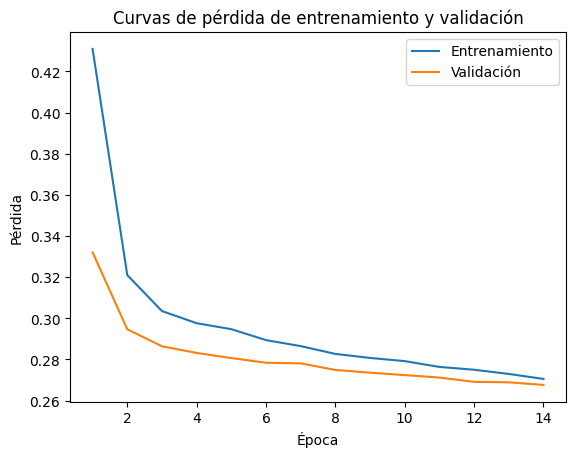

In [16]:
# Generamos una gráfica que muestra la evolución de la pérdida durante el entrenamiento y la validación a lo largo de las iteraciones.
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Entrenamiento')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curvas de pérdida de entrenamiento y validación')
plt.legend()
plt.show()

In [ ]:
# Descargar modelo

torch.save(best_model.state_dict(), 'HC_model.pth')

## Ejemplo de recomendaciones para usuarios

Definimos la función `recommend_books_for_user`, que genera una lista de libros recomendados para un usuario, combinando embeddings estructurales (LightGCN) y de contenido (TF-IDF).

Por otro lado, `show_user_profile_from_interactions` permite visualizar los libros con los que un usuario ha interactuado positivamente.

In [18]:
@torch.no_grad()  # Desactiva el cálculo de gradientes durante la inferencia
def recommend_books_for_user(user_id, model, user_embeddings_gcn,
                             item_embeddings_gcn_filtered, tfidf_tensor_filtered,
                             valid_book_ids, book_id_to_title,
                             user_seen_books=None, top_k=10,
                             device="cuda" if torch.cuda.is_available() else "cpu"):

    model.eval()
    model.to(device)

    # Validación del ID de usuario
    if user_id >= user_embeddings_gcn.shape[0]:
        raise ValueError(f"user_id {user_id} fuera de rango. Máximo permitido: {user_embeddings_gcn.shape[0]-1}")

    # Filtramos los embeddings de usuario y libros
    user_embedding = user_embeddings_gcn[user_id].to(device)

    scores = []
    candidates = []

    for idx, book_id in enumerate(valid_book_ids):
        # Omitimos libros que el usuario ya ha visto, si se proporciona esa información
        if user_seen_books and book_id in user_seen_books:
            continue

        gcn_item = item_embeddings_gcn_filtered[idx].to(device)
        tfidf_item = tfidf_tensor_filtered[idx].to(device)

        # Combinación del embedding del usuario con el del ítem (producto elemento a elemento)
        gcn_emb = user_embedding * gcn_item

        # Inferencia
        score = torch.sigmoid(model(gcn_emb.unsqueeze(0), tfidf_item.unsqueeze(0))).item()

        scores.append(score)
        candidates.append(book_id)

    # Selección de los k libros con mayor puntuación
    top_k_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
    top_k_books = [candidates[i] for i in top_k_indices]

    # Devolvemos una lista con ID de libro, título y puntuación
    return [(book_id, book_id_to_title.get(book_id, "Unknown"), scores[i]) for i, book_id in zip(top_k_indices, top_k_books)]


def show_user_profile_from_interactions(user_id, interactions_list, book_id_to_title):
    # Diccionario de usuario -> lista de libros con interacciones positivas
    user_interactions = defaultdict(list)
    for u_id, b_id, label in interactions_list:
        if label == 1:
            user_interactions[u_id].append(b_id)

    # Extraemos los libros del usuario deseado
    user_books = user_interactions.get(user_id, [])

    if not user_books:
        print(f"El usuario {user_id} no tiene libros en su perfil.")
        return

    print(f"Perfil de usuario {user_id} - libros leídos/interactuados positivamente:")
    for book_id in user_books:
        title = book_id_to_title.get(book_id, "Título desconocido")
        print(f"- {title} (Book ID: {book_id})")
    print()

Probamos a recomendar libros a un usuario.

In [19]:
# Diccionario para mapear book_id a título
book_id_to_title = dict(zip(books['book_id'], books['title']))

# Ejemplo de usuario
user_id = 14

# Mostrar perfil del usuario
show_user_profile_from_interactions(user_id, interactions_list, book_id_to_title)

# Mostrar recomendaciones
recommendations = recommend_books_for_user(
    user_id=user_id,
    model=best_model,
    user_embeddings_gcn=user_embeddings_gcn,
    item_embeddings_gcn_filtered=item_embeddings_gcn_filtered,
    tfidf_tensor_filtered=tfidf_tensor_filtered,
    valid_book_ids=valid_book_ids,
    book_id_to_title=book_id_to_title,
    top_k=10
)

# Mostrar resultados
print(f"Recomendaciones para el usuario {user_id}:")
for rank, (book_id, title, score) in enumerate(recommendations, 1):
    print(f"{rank:2d}. {title} (Book ID: {book_id})")


Perfil de usuario 14 - libros leídos/interactuados positivamente:
- Dicey's Song (Tillerman Cycle, #2) (Book ID: 11831)
- Vampire Mountain (Cirque Du Freak, #4) (Book ID: 8960)
- Absolutely Mahvelous (Book ID: 10943)
- King Dork (King Dork, #1) (Book ID: 10570)
- Trials of Death (Cirque Du Freak, #5) (Book ID: 8967)

Recomendaciones para el usuario 14:
 1. King Dork (King Dork, #1) (Book ID: 10570)
 2. The Lake of Souls (Book ID: 8951)
 3. Creepy Condors of California (American Chillers, #14) (Book ID: 79640)
 4. Cuba 15 (Book ID: 10431)
 5. Rebel Angels (Gemma Doyle, #2) (Book ID: 51428)
 6. On Fortune's Wheel (Tales of the Kingdom, #2) (Book ID: 95914)
 7. Vampire Mountain (Cirque Du Freak, #4) (Book ID: 8960)
 8. The Red Dice (The Last Vampire #3) (Book ID: 137970)
 9. Trials of Death (Cirque Du Freak, #5) (Book ID: 8967)
10. Then He Ate My Boy Entrancers (Confessions of Georgia Nicolson, #6) (Book ID: 112693)
